### Importation of libraries and functions

In [1]:
from utils import *
from pathlib import Path
from IPython.display import Latex

%matplotlib inline
%load_ext lab_black

### Ignore "FutureWarning" Errors

In [2]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

### Ignore Errors linked to the Caveat

In [3]:
pd.options.mode.chained_assignment = None

### Definition of the paths

In [4]:
data_folder = "/home/gillard/Bureau/MISP_Analysis/Back-up/WEIS2022"
output_folder = "/home/gillard/Bureau/MISP_Analysis/Back-up/WEIS2022"
image_folder = "images"
Path(f"{image_folder}").mkdir(parents=True, exist_ok=True)

### Dataframes Loading

The dataframes have been obtained by running MISP_Retrieve.py via MISP API and transformed by running MISP_export.ipynb.
The following dataframes are loaded:

1. Events.csv
1. Attributes.csv
1. Organisations.csv
1. Tags.csv
1. Related_Events.csv --> Not available on the MISP Instance for the moment

In [5]:
events = pd.read_csv(f"{data_folder}/Events.csv")  # , nrows=10000)
attributes = pd.read_csv(f"{data_folder}/Attributes.csv")  # , nrows=1000000)
tags = pd.read_csv(f"{data_folder}/Tags.csv")  # , nrows=10000)
organisations = pd.read_csv(f"{data_folder}/Organisations.csv")  # , nrows=10000)
# related_events = pd.read_csv(f'{data_folder}/Related_Events.csv')


events = events[events["Orgc ID"] != 1203]
events = events.reset_index(drop=True)

attributes = attributes[attributes["Orgc ID"] != 1203]
attributes = attributes.reset_index(drop=True)

organisations = organisations[organisations["Org ID"] != 1203]
organisations = organisations.reset_index(drop=True)

tags = tags[tags["Orgc ID"] != 1203]
tags = tags.reset_index(drop=True)

events = events.sort_values(by=["Date"], ascending=True)

EcoModel = pd.read_csv(f"{data_folder}/EcoModel.csv")

/home/gillard/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning: Columns (0,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
print("Dataframe: events \n")
events.info()

print("Dataframe: attributes \n")
attributes.info()

print("Dataframe: tags \n")
tags.info()

print("Dataframe: organisations \n")
organisations.info()

EcoModel.info()

Dataframe: events 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39639 entries, 1241 to 39638
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Event ID              39639 non-null  int64 
 1   Orgc ID               39639 non-null  int64 
 2   Org ID                39639 non-null  int64 
 3   Org event creator     39639 non-null  object
 4   Org UUID              39639 non-null  object
 5   Date                  39639 non-null  object
 6   Threat Level ID       39639 non-null  int64 
 7   Published             39639 non-null  bool  
 8   UUID                  39639 non-null  object
 9   Attribute Count       39639 non-null  int64 
 10  Related Events Count  39639 non-null  int64 
 11  Analysis              39639 non-null  int64 
 12  Timestamp             39639 non-null  int64 
 13  Distribution          39639 non-null  int64 
 14  Published Timestamp   39639 non-null  int64 
 15  Info         

### 0. Summary Statistics

In [7]:
Eventsnb = len(events["Event ID"])
Orgsnb = len(organisations["Org ID"])
Attrnb = len(attributes["Attribute ID"])
ContrOrg = len(events["Orgc ID"].value_counts())
Users = np.sum(organisations["User Count"])
UserperOrg = Users / float(len(organisations["Org ID"]))
CompletedE = len(events[events["Analysis"] == 2])
AttrperE = float(len(attributes["Attribute ID"])) / float(len(events["Event ID"]))
TagsperE = float(len(tags["Tag ID"])) / float(len(events["Event ID"]))

k = events[events["Analysis"] == 2]["Event ID"].tolist()
ComplEAttr = len(attributes[attributes["Event ID"].isin(k)])
UniqueTags = len(tags[tags.duplicated(subset=["Tag ID"]) == False])
CumTags = len(tags["Tag ID"])
TagspercomplE = len(tags[tags["Event ID"].isin(k)])


MeanUserperOrg = np.mean(organisations["User Count"])
StdUserperOrg = np.std(organisations["User Count"])
print("MeanUserperOrg = ", MeanUserperOrg, "\n", "StdUserperOrg =", StdUserperOrg)


print(
    "Eventsnb",
    Eventsnb,
    "\n",
    "Orgsnb",
    Orgsnb,
    "\n",
    "Attrnb",
    Attrnb,
    "\n",
    "ContrOrg",
    ContrOrg,
    "\n",
    "Users",
    Users,
    "\n",
    "UserperOrg",
    UserperOrg,
    "\n",
    "CompletedE",
    CompletedE,
    "\n",
    "AttrperE",
    AttrperE,
    "\n",
    "TagsperE",
    TagsperE,
    "\n",
    "ComplEAttr",
    ComplEAttr,
    "\n",
    "UniqueTags",
    UniqueTags,
    "\n",
    "CumTags",
    CumTags,
    "\n",
    "TagspercomplE",
    TagspercomplE,
)

MeanUserperOrg =  2.103249475890985 
 StdUserperOrg = 3.3543878967824274
Eventsnb 39639 
 Orgsnb 1908 
 Attrnb 9099685 
 ContrOrg 485 
 Users 4013 
 UserperOrg 2.103249475890985 
 CompletedE 22423 
 AttrperE 229.56393955447916 
 TagsperE 2.9366785236761777 
 ComplEAttr 2517610 
 UniqueTags 3786 
 CumTags 116407 
 TagspercomplE 68959


### 1. Plot CCDF

1. CCDF Number of attributes per event
1. CCDF Number of events per org
1. CCDF Number of tags per event
1. Panel with the three plots above


### 1.1 CCDF Number of attributes per event

In [8]:
x1, y1 = rankorder(attributes["Event ID"])
y11 = y1 / float(max(y1))


myplfit1 = plfit(x1, xmin=13, discrete=True, discrete_approx=True, verbose=True)

print(myplfit1)

x1d = np.logspace(1, 5, 10000)
y_fit1 = []
for idz, z in enumerate(x1d):
    y_fit1.append(z ** (-0.64494) * 2)

The lowest value included in the power-law fit,  xmin: 13 
The number of values above xmin,  n(>xmin): 15763 
The derived power-law alpha (p(x)~x^-alpha) with MLE-derived error,  alpha: 1.64494 +/- 0.00513688   
The log of the Likelihood (the maximized parameter; you minimized the negative log likelihood),  Log-Likelihood: -87549   
The KS-test statistic between the best-fit power-law and the data,  ks: 0.0663714  occurs with probability   p(ks): 4.06318e-61


### 1.2 CCDF Number of events per org

In [9]:
x2, y2 = rankorder(events["Orgc ID"])
y22 = y2 / float(max(y2))


myplfit2 = plfit(x2, xmin=3.0, discrete=True, discrete_approx=True, verbose=True)

print(myplfit2)


y_fit2 = []

for idz, z in enumerate(x2):
    y_fit2.append(z ** (-0.54346))

The lowest value included in the power-law fit,  xmin: 3 
The number of values above xmin,  n(>xmin): 232 
The derived power-law alpha (p(x)~x^-alpha) with MLE-derived error,  alpha: 1.54346 +/- 0.0356802   
The log of the Likelihood (the maximized parameter; you minimized the negative log likelihood),  Log-Likelihood: -1055.24   
The KS-test statistic between the best-fit power-law and the data,  ks: 0.150862  occurs with probability   p(ks): 2.24232e-05


### 1.2.1 Table 1: 10 bigger contributors

In [10]:
Bigger_contributors = events["Orgc ID"].value_counts()
Table = Bigger_contributors[0:10]
print(Table)
print(np.sum(Table))
print(np.sum(Table / len(events["Event ID"])))

1092    7682
1395    5637
1960    3214
2       2939
1857    1411
201     1247
1713    1141
698     1077
204     1060
643      998
Name: Orgc ID, dtype: int64
26406
0.6661621130704609


### 1.3 CCDF Number of tags per event

In [11]:
x3, y3 = rankorder(tags["Event ID"])
y33 = y3 / float(max(y3))


# x3 = []
# for idk, k in enumerate(x):
#     if k >= 1:
#         x1.append(k)

# myplfit3 = plfit(x1, discrete=True, discrete_approx=True, verbose=True)
myplfit3 = plfit(x3, xmin=9.0, discrete=True, discrete_approx=True, verbose=True)

print(myplfit3)

x3d = np.linspace(3, 10 ** 2, 100)
y_fit3 = []
for idz, z in enumerate(x3d):
    y_fit3.append(z ** (-2.26015) * 3.4)

The lowest value included in the power-law fit,  xmin: 9 
The number of values above xmin,  n(>xmin): 1216 
The derived power-law alpha (p(x)~x^-alpha) with MLE-derived error,  alpha: 3.26015 +/- 0.0648143   
The log of the Likelihood (the maximized parameter; you minimized the negative log likelihood),  Log-Likelihood: -3434.28   
The KS-test statistic between the best-fit power-law and the data,  ks: 0.152138  occurs with probability   p(ks): 2.43174e-25


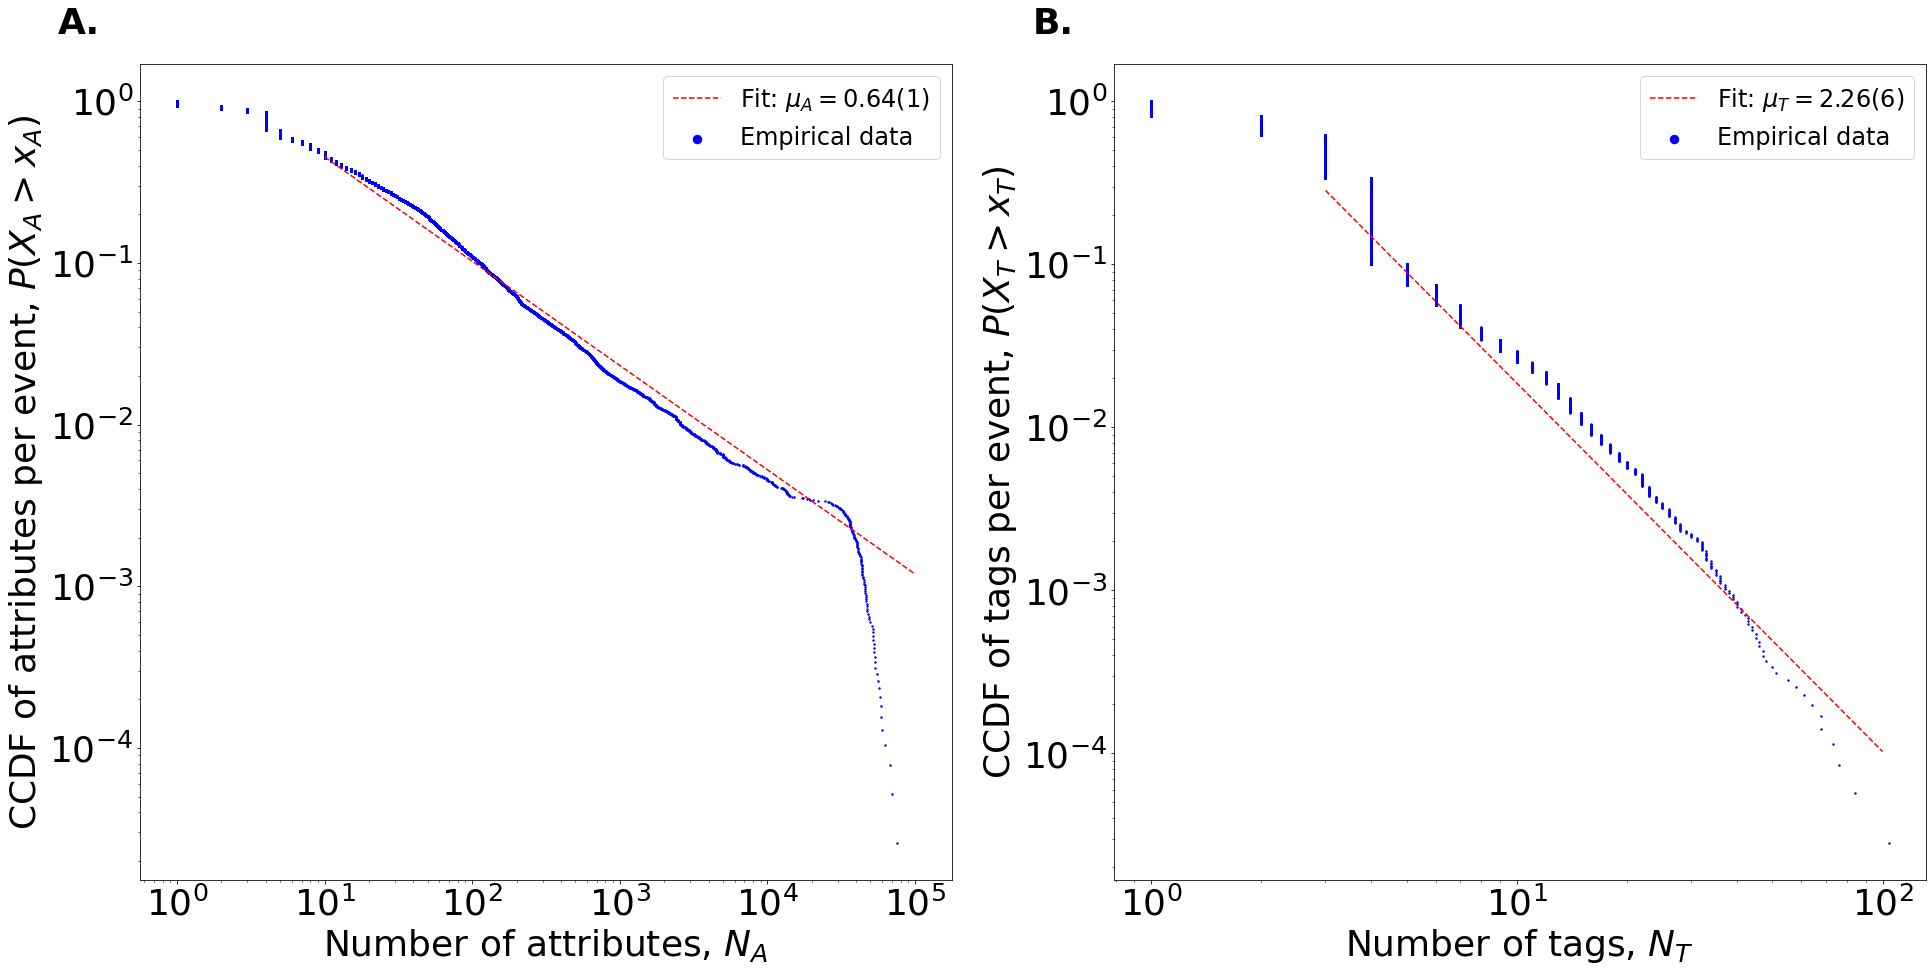

In [12]:
fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(32, 15))

ax1.scatter(x1, y11, s=2, color="b", label="Empirical data")
ax1.plot(
    x1d,
    y_fit1,
    ls="--",
    color="r",
    label=r"Fit: $\mu_A = 0.64(1)$",
)
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel(r"Number of attributes, $N_A$", fontsize=36)
ax1.set_ylabel(
    "CCDF of attributes per event, $P(X_A>x_A)$",
    fontsize=36,
)
ax1.legend(loc="best", markerscale=6, fontsize=24)
ax1.text(
    -0.05,
    1.07,
    "A.",
    transform=ax1.transAxes,
    fontsize=36,
    fontweight="bold",
    va="top",
    ha="right",
)
ax1.xaxis.set_tick_params(labelsize=36)
ax1.yaxis.set_tick_params(labelsize=36)

ax3.scatter(x3, y33, s=2, color="b", label="Empirical data")
ax3.plot(
    x3d,
    y_fit3,
    ls="--",
    color="r",
    label=r"Fit: $\mu_T = 2.26(6)$",
)
ax3.set_xscale("log")
ax3.set_yscale("log")
ax3.set_xlabel(r"Number of tags, $N_T$", fontsize=36)
ax3.set_ylabel("CCDF of tags per event, $P(X_T > x_T)$", fontsize=36)
ax3.legend(loc="best", markerscale=6, fontsize=24)
ax3.text(
    -0.05,
    1.07,
    "B.",
    transform=ax3.transAxes,
    fontsize=36,
    fontweight="bold",
    va="top",
    ha="right",
)
ax3.xaxis.set_tick_params(labelsize=36)
ax3.yaxis.set_tick_params(labelsize=36)

plt.savefig("/home/gillard/Bureau/MISP_Analysis/Publications/Figure2.png", format="png")

### 2. Plot: Arrival + Contribution of Org

### 2.1 Transformations

In [13]:
base_dt = pd.to_datetime("1970/01/01 00:00:00")

org = organisations[organisations["Date created"] != str("0000-00-00 00:00:00")]

org["Date created"] = pd.to_datetime(org["Date created"])
org["Date created"] = (org["Date created"] - base_dt).dt.total_seconds()
org["Date created"] = org["Date created"] / (3600.0 * 24.0)

events["Date"] = pd.to_datetime(events["Date"])
# print(events["Date"])
# events["Date"] = (events["Date"] - base_dt).dt.total_seconds()
# events["Date"] = events["Date"] / (3600.0 * 24.0)
# print(events["Date"])

### Linear regression

In [14]:
# org["Date created"] = org["Date created"] / (3600.0 * 24.0 * 365.25)

# print(org["Date created"])

x1 = np.linspace(1.4e9 / (3600 * 24), max(org["Date created"]), 1000)

res1 = stats.linregress(org["Date created"], org["Org ID"])
print(res1)

y11 = res1.slope * x1 + res1.intercept

calcLogLikelihood(
    res1.slope * org["Date created"] + res1.intercept, org["Org ID"], len(org["Org ID"])
)

LinregressResult(slope=0.793371763916261, intercept=-13079.855193740917, rvalue=0.9956577539064554, pvalue=0.0, stderr=0.0017213173896208009, intercept_stderr=30.61374481695484)


/home/gillard/Bureau/MISP_Analysis/Python Scripts/utils.py:350: RuntimeWarning: divide by zero encountered in log
  return np.log(f)


-inf

### 2.3 Plot

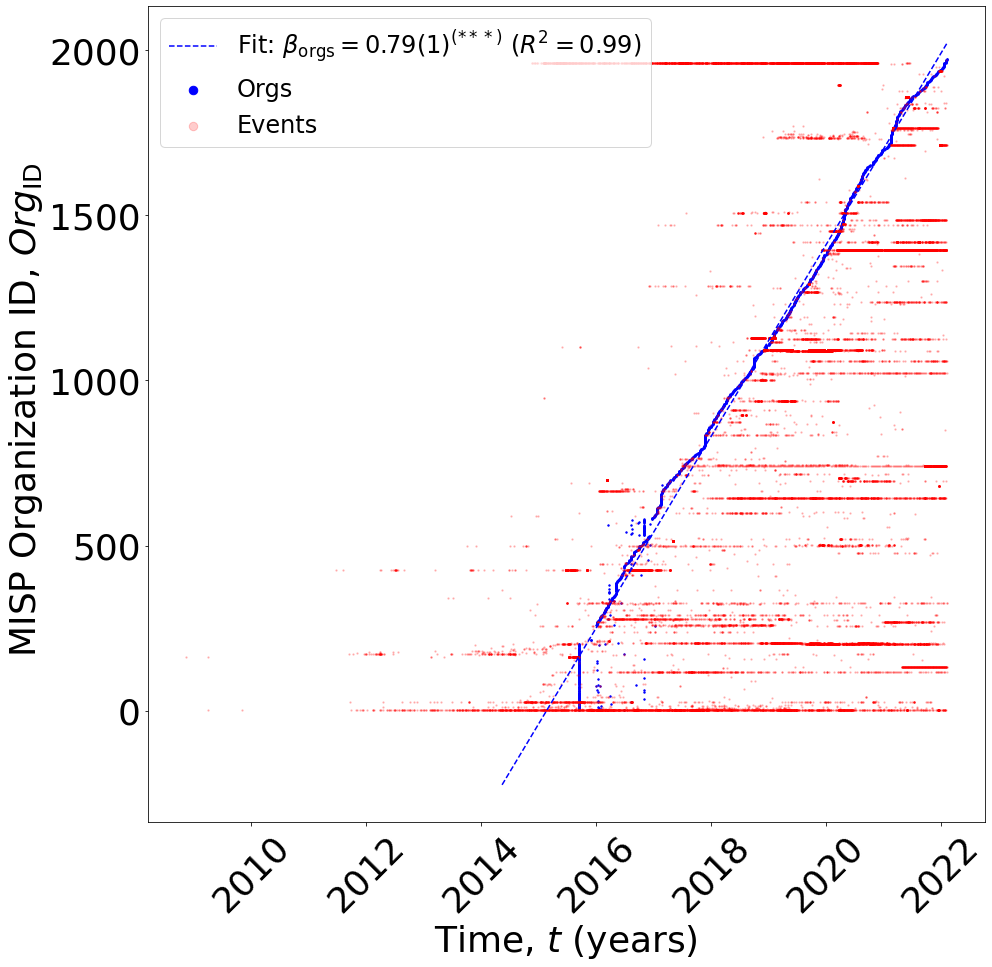

In [15]:
fig1, ax1 = plt.subplots(1, 1, figsize=(15, 15))
ax1.scatter(org["Date created"], org["Org ID"], s=2, color="b", label="Orgs")
ax1.scatter(
    events["Date"], events["Orgc ID"], s=2, color="r", label="Events", alpha=0.2
)

ax1.plot(
    x1,
    y11,
    color="b",
    ls="--",
    label=r"Fit: $\beta_{\mathrm{orgs}} = 0.79(1)^{(***)}$ ($R^2 = 0.99$)",
)

ax1.set_xlabel(r"Time, $t$ (years)", fontsize=36)
ax1.set_ylabel(r" MISP Organization ID, $Org_{\mathrm{ID}}$", fontsize=36)
# ax1.text(-0.05, 1.05, 'A.', transform=ax1.transAxes,fontsize=36, fontweight='bold', va='top', ha='right')
ax1.xaxis.set_tick_params(labelsize=36)
ax1.yaxis.set_tick_params(labelsize=36)


ax1.set_xticks(
    [
        datetime(2010, 1, 1, 1, 0).timestamp() / (3600 * 24),
        datetime(2012, 1, 1, 1, 0).timestamp() / (3600 * 24),
        datetime(2014, 1, 1, 1, 0).timestamp() / (3600 * 24),
        datetime(2016, 1, 1, 1, 0).timestamp() / (3600 * 24),
        datetime(2018, 1, 1, 1, 0).timestamp() / (3600 * 24),
        datetime(2020, 1, 1, 1, 0).timestamp() / (3600 * 24),
        datetime(2022, 1, 1, 1, 0).timestamp() / (3600 * 24),
    ]
)
ax1.set_xticklabels(
    [
        "2010",
        "2012",
        "2014",
        "2016",
        "2018",
        "2020",
        "2022",
    ],
    rotation=45,
)
ax1.legend(loc="upper left", markerscale=6, fontsize=24)

### 3. Plot $\Delta t$  vs time

### 3.1 Transformations

In [16]:
EcoModel = pd.read_csv(f"{data_folder}/EcoModel.csv")

Reg_var = EcoModel[
    [
        "CTime",
        "CompletionT",
    ]
]

print(min(Reg_var["CTime"]))

Reg_var["CTime_Month"] = seconds_to_months(Reg_var["CTime"] - min(Reg_var["CTime"]))
print(Reg_var)

Months = Reg_var["CTime_Month"].value_counts()
Months = Months.keys().sort_values(ascending=True)

Mean_values = []

for idx, x in enumerate(Months):
    Regroup = Reg_var[Reg_var["CTime_Month"] == x]
    Mean_values.append(Regroup.mean(axis=0).tolist())

Reg_var_binned = pd.DataFrame(
    Mean_values,
    columns=[
        "CTime",
        "CompletionT",
        "CTime_Month",
    ],
)

1226275200
            CTime  CompletionT  CTime_Month
0      1226275200    210610270          0.0
1      1238284800    156517432          5.0
2      1238284800    198601017          5.0
3      1257033600    170441124         12.0
4      1308700800    298823656         32.0
...           ...          ...          ...
39634  1644192000        60214        162.0
39635  1644278400        30370        162.0
39636  1644278400        54633        162.0
39637  1644278400        35589        162.0
39638  1644278400        59111        162.0

[39639 rows x 3 columns]


### 3.2 Piece-wise fit

In [17]:
Fit = Reg_var_binned[(Reg_var_binned["CTime_Month"] > 2)]
print(Fit)
y = np.log10(Fit["CompletionT"]).tolist()

reg = piecewise_regression.Fit(Fit["CTime_Month"].tolist(), y, n_breakpoints=1)
print(reg.summary())

            CTime   CompletionT  CTime_Month
1    1.238285e+09  1.775592e+08          5.0
2    1.257034e+09  1.704411e+08         12.0
3    1.308701e+09  2.988237e+08         32.0
4    1.312330e+09  2.951949e+08         34.0
5    1.316390e+09  1.550324e+08         35.0
..            ...           ...          ...
128  1.634545e+09  2.581768e+05        158.0
129  1.637255e+09  1.728758e+05        159.0
130  1.640478e+09  8.144829e+04        160.0
131  1.642018e+09  8.487356e+04        161.0
132  1.643938e+09  6.817810e+04        162.0

[132 rows x 3 columns]

                    Breakpoint Regression Results                     
No. Observations                      132
No. Model Parameters                    4
Degrees of Freedom                    128
Res. Sum of Squares               9.86761
Total Sum of Squares              71.0874
R Squared                        0.861190
Adjusted R Squared               0.856819
Converged:                           True
                    Estimate

### 3.3 Plot

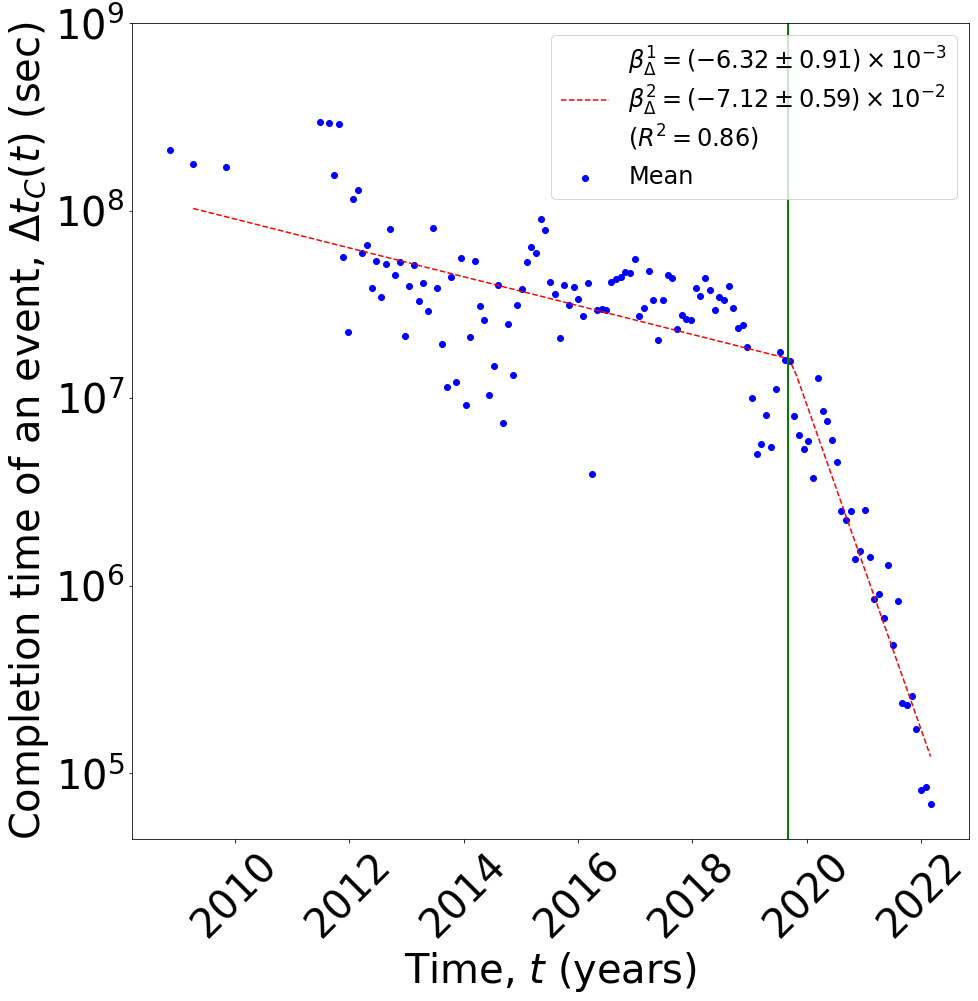

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.scatter(
    Reg_var_binned["CTime_Month"],
    np.log10(Reg_var_binned["CompletionT"]),
    color="blue",
    label="Mean",
)
reg.plot_fit(
    color="red",
    ls="--",
    label=r"$\beta_{\Delta}^1 = (-6.32 \pm 0.91) \times 10^{-3}$"
    + "\n"
    + r"$\beta_{\Delta}^2 = (-7.12 \pm 0.59) \times 10^{-2}$"
    + "\n"
    + r"($R^2 = 0.86$)",
)

ax.set_xlabel(r"Time, $t$ (years)", fontsize=40)
ax.set_ylabel(r"Completion time of an event, $\Delta t_C(t)$ (sec)", fontsize=40)


ax.axvline(
    x=(datetime(2020, 1, 1, 1, 0).timestamp() - min(Reg_var["CTime"]))
    / (3600 * 24.0 * 30)
    - 4,
    ymin=0,
    ymax=10 ** 9,
    color="green",
    lw=2,
)

ax.set_xticks(
    [
        (datetime(2010, 1, 1, 1, 0).timestamp() - min(Reg_var["CTime"]))
        / (3600 * 24.0 * 30),
        (datetime(2012, 1, 1, 1, 0).timestamp() - min(Reg_var["CTime"]))
        / (3600 * 24.0 * 30),
        (datetime(2014, 1, 1, 1, 0).timestamp() - min(Reg_var["CTime"]))
        / (3600 * 24.0 * 30),
        (datetime(2016, 1, 1, 1, 0).timestamp() - min(Reg_var["CTime"]))
        / (3600 * 24.0 * 30),
        (datetime(2018, 1, 1, 1, 0).timestamp() - min(Reg_var["CTime"]))
        / (3600 * 24.0 * 30),
        (datetime(2020, 1, 1, 1, 0).timestamp() - min(Reg_var["CTime"]))
        / (3600 * 24.0 * 30),
        (datetime(2022, 1, 1, 1, 0).timestamp() - min(Reg_var["CTime"]))
        / (3600 * 24.0 * 30),
    ]
)
ax.set_xticklabels(
    [
        "2010",
        "2012",
        "2014",
        "2016",
        "2018",
        "2020",
        "2022",
    ],
    rotation=45,
)

ax.set_yticks([5, 6, 7, 8, 9])
ax.set_yticklabels([r"$10^5$", r"$10^6$", r"$10^7$", r"$10^8$", r"$10^9$"])

ax.xaxis.set_tick_params(labelsize=40)
ax.yaxis.set_tick_params(labelsize=40)
ax.legend(fontsize=24, loc="upper right")

### 4. CCDF $\Delta t$

### 4.1 Transformations

In [19]:
EcoModel["CompletionT"] = EcoModel["CompletionT"].abs()
Ecox = EcoModel["CompletionT"].sort_values(ascending=False)
Ecox = Ecox / 1e8
Ecoy = np.arange(0, len(Ecox), 1)
m = max(Ecoy)
Ecoy = np.log10(Ecoy / max(Ecoy))
Ecoy = Ecoy.tolist()

x = []
y = []
for ide, e in enumerate(Ecox):
    if e > 0.2 and e < 3.2:
        x.append(e)
        y.append(Ecoy[ide])
# yy = y / m

# ylog = np.log10(yy)
# print(ylog)

res = stats.linregress(x, y)
print(res)

k = np.linspace(min(Ecox), 3.2, 1000)

y_fit = res.slope * k + res.intercept

LinregressResult(slope=-0.9308938849166892, intercept=-0.5642500795290031, rvalue=-0.9834709498826288, pvalue=0.0, stderr=0.0022003335163390545, intercept_stderr=0.0018898649775953122)


/tmp/ipykernel_113996/4175105244.py:6: RuntimeWarning: divide by zero encountered in log10
  Ecoy = np.log10(Ecoy / max(Ecoy))


In [20]:
%%script echo skipping
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

ax.scatter(Ecox, Ecoy, s=2, color="b", label="Empirical data")
# ax.scatter(x, y, s=2, color="g", label="Empirical data")
ax.plot(
    k,
    y_fit,
    ls="--",
    color="r",
    label=r"Fit: $\beta_{\Delta} = -0.93(1)^{(***)}$ $(R^2 = 0.97)$",
)

ax.set_xlabel(
    r"Completion time of an event, $\Delta t_C$ $(\times 10^8s)$", fontsize=36
)
ax.set_ylabel(
    "CCDF of $\Delta t_C$, $P(X_{\Delta}>x_{\Delta})$",
    fontsize=36,
)
ax.legend(loc="best", fontsize=24)
ax.set_yticks([-4, -3, -2, -1, 0])
ax.set_yticklabels([r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$", r"$0$"])
# ax.text(
#     -0.05,
#     1.05,
#     "B.",
#     transform=ax.transAxes,
#     fontsize=36,
#     fontweight="bold",
#     va="top",
#     ha="right",
# )
ax.xaxis.set_tick_params(labelsize=36)
ax.yaxis.set_tick_params(labelsize=36)

skipping


In [21]:
%%script echo skipping
EcoModel["CompletionT"] = EcoModel["CompletionT"].abs()

EcoModel = EcoModel[EcoModel["CompletionT"] > 0]
plt.figure(figsize=(10, 10))
sns.distplot(EcoModel["CompletionT"])

skipping


### 4. Plot Cumulated Attributes in Galaxies

### 4.1 Transformations

In [22]:
%%script echo skipping
galaxies = pd.read_csv(f"{data_folder}/Galaxies.csv")

galaxies = galaxies[galaxies["Galaxy ID"] != 1203]
galaxies = galaxies.reset_index(drop=True)

CumGalaxyE = np.zeros(len(EcoModel["Event ID"]))
CumGalaxyE2 = np.zeros(len(EcoModel["Event ID"]))  # Events in several Galaxies
NbofGalperE = np.zeros(len(EcoModel["Event ID"]))
k = 0
for idg, g in enumerate(EcoModel["Event ID"]):
    k = len(galaxies[galaxies["Event ID"] == g])
    NbofGalperE[idg] = k
    if k > 0:
        if idg == 0:
            CumGalaxyE[idg] += 1
            CumGalaxyE2[idg] += k
        else:
            CumGalaxyE[idg] = CumGalaxyE[idg - 1] + 1
            CumGalaxyE2[idg] = CumGalaxyE2[idg - 1] + 1
    else:
        CumGalaxyE[idg] = CumGalaxyE[idg - 1]
        CumGalaxyE2[idg] = CumGalaxyE2[idg - 1]
print(CumGalaxyE)
print(CumGalaxyE2)

skipping


In [23]:
%%script echo skipping
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

ax.scatter(EcoModel["CTime"], CumGalaxyE, s=2, color="b")
ax.scatter(EcoModel["CTime"], CumGalaxyE2, s=2, color="r")
ax.set_xlabel(r"Creation Time of events", fontsize=36)
ax.set_ylabel(
    "Cumulated events in Galaxies",
    fontsize=36,
)
# ax.set_yscale("log")
# ax.set_xscale("log")
ax.set_xticks(
    [
        datetime(2010, 1, 1, 1, 0).timestamp(),
        datetime(2012, 1, 1, 1, 0).timestamp(),
        datetime(2014, 1, 1, 1, 0).timestamp(),
        datetime(2016, 1, 1, 1, 0).timestamp(),
        datetime(2018, 1, 1, 1, 0).timestamp(),
        datetime(2020, 1, 1, 1, 0).timestamp(),
        datetime(2022, 1, 1, 1, 0).timestamp(),
    ]
)
ax.set_xticklabels(
    [
        "2010",
        "2012",
        "2014",
        "2016",
        "2018",
        "2020",
        "2022",
    ],
    rotation=45,
)
ax.xaxis.set_tick_params(labelsize=36)
ax.yaxis.set_tick_params(labelsize=36)

skipping


In [24]:
%%script echo skipping
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

ax.scatter(EcoModel["CTime"], NbofGalperE, s=2, color="b")

skipping


# Plot 2

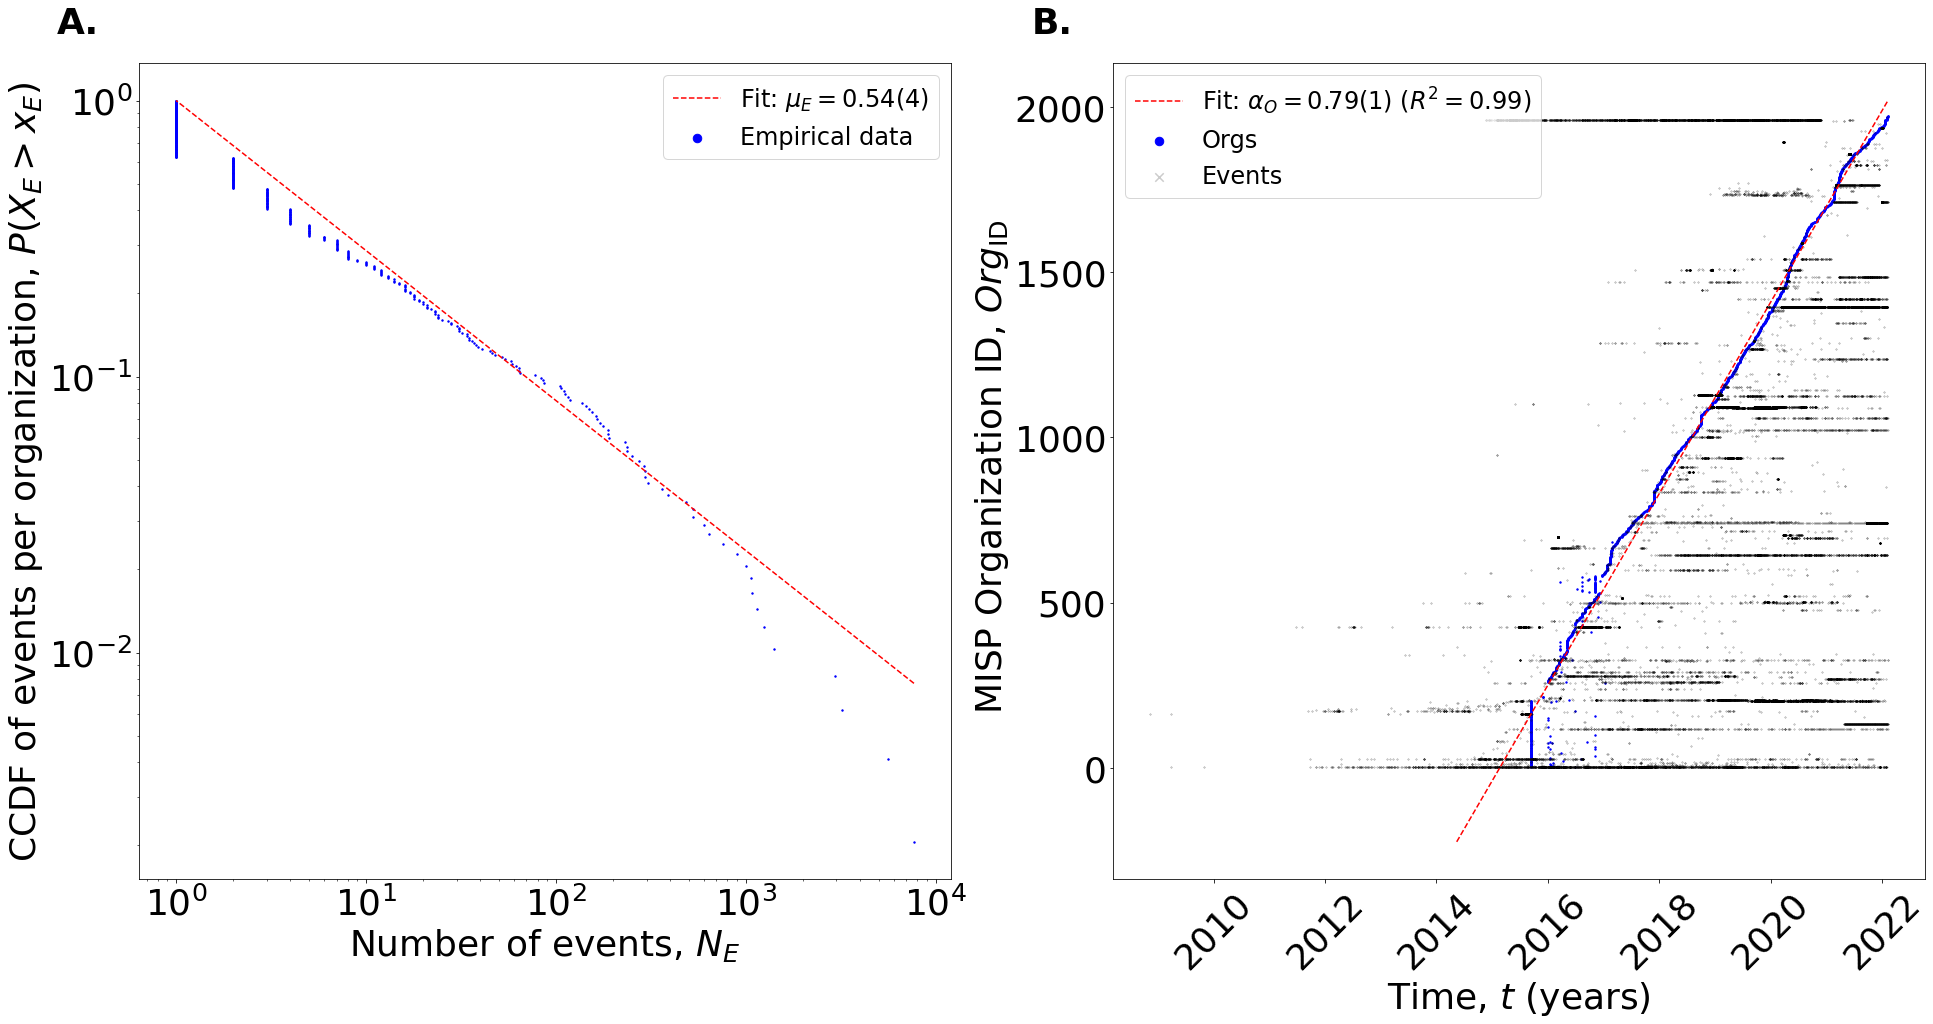

In [25]:
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(32, 15))

ax2.scatter(x2, y22, s=2, color="b", label="Empirical data")
ax2.plot(
    x2,
    y_fit2,
    ls="--",
    color="r",
    label=r"Fit: $\mu_E = 0.54(4)$",
)
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_xlabel(r"Number of events, $N_E$", fontsize=36)
ax2.set_ylabel(
    "CCDF of events per organization, $P(X_E>x_E)$",
    fontsize=36,
)
ax2.legend(loc="best", markerscale=6, fontsize=24)
ax2.text(
    -0.05,
    1.07,
    "A.",
    transform=ax2.transAxes,
    fontsize=36,
    fontweight="bold",
    va="top",
    ha="right",
)
ax2.xaxis.set_tick_params(labelsize=36)
ax2.yaxis.set_tick_params(labelsize=36)

ax1.scatter(org["Date created"], org["Org ID"], s=2, color="b", label="Orgs")
ax1.scatter(
    events["Date"],
    events["Orgc ID"],
    s=2,
    color="black",
    marker="x",
    label="Events",
    alpha=0.2,
)

ax1.plot(
    x1,
    y11,
    color="r",
    ls="--",
    label=r"Fit: $\alpha_O = 0.79(1)$ ($R^2 = 0.99$)",
)

ax1.set_xlabel(r"Time, $t$ (years)", fontsize=36)
ax1.set_ylabel(r" MISP Organization ID, $Org_{\mathrm{ID}}$", fontsize=36)
ax1.text(
    -0.05,
    1.07,
    "B.",
    transform=ax1.transAxes,
    fontsize=36,
    fontweight="bold",
    va="top",
    ha="right",
)
ax1.xaxis.set_tick_params(labelsize=36)
ax1.yaxis.set_tick_params(labelsize=36)


ax1.set_xticks(
    [
        datetime(2010, 1, 1, 1, 0).timestamp() / (3600 * 24),
        datetime(2012, 1, 1, 1, 0).timestamp() / (3600 * 24),
        datetime(2014, 1, 1, 1, 0).timestamp() / (3600 * 24),
        datetime(2016, 1, 1, 1, 0).timestamp() / (3600 * 24),
        datetime(2018, 1, 1, 1, 0).timestamp() / (3600 * 24),
        datetime(2020, 1, 1, 1, 0).timestamp() / (3600 * 24),
        datetime(2022, 1, 1, 1, 0).timestamp() / (3600 * 24),
    ]
)
ax1.set_xticklabels(
    [
        "2010",
        "2012",
        "2014",
        "2016",
        "2018",
        "2020",
        "2022",
    ],
    rotation=45,
)
ax1.legend(loc="upper left", markerscale=6, fontsize=24)

plt.savefig("/home/gillard/Bureau/MISP_Analysis/Publications/Figure1.png", format="png")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


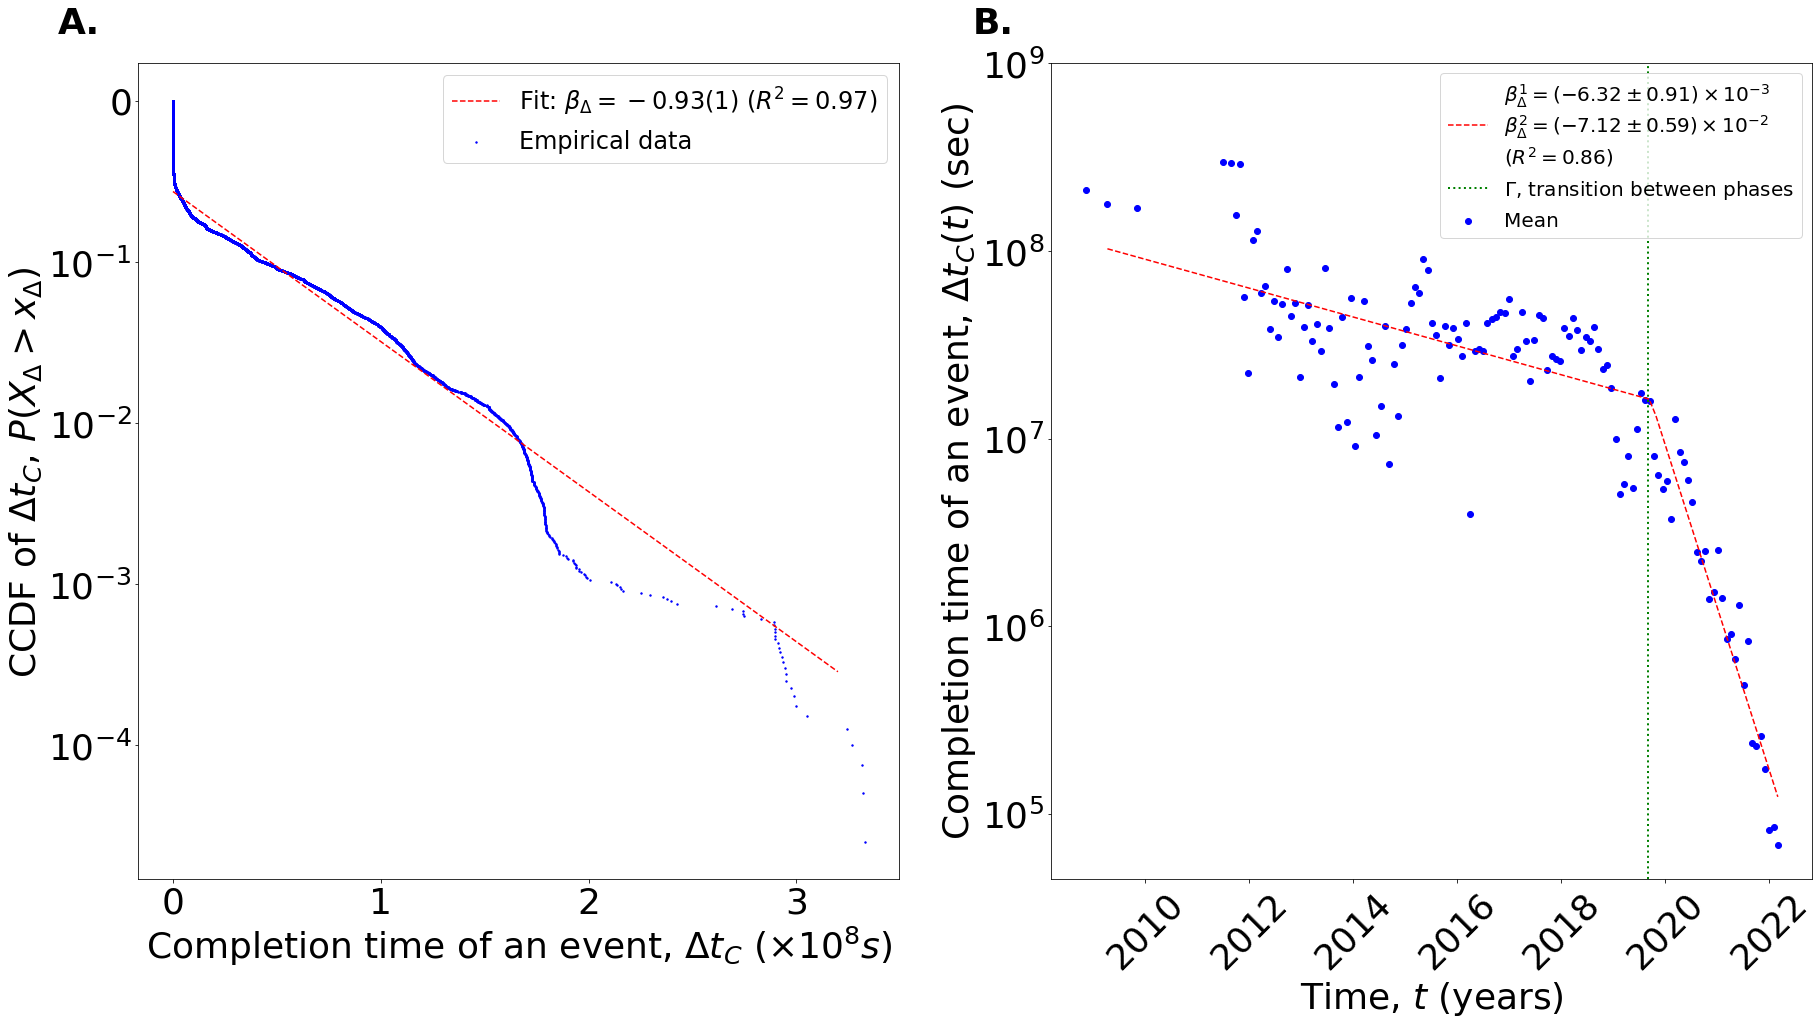

In [26]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(30, 15))

ax1.scatter(
    Reg_var_binned["CTime_Month"],
    np.log10(Reg_var_binned["CompletionT"]),
    color="blue",
    label="Mean",
)
reg.plot_fit(
    color="red",
    ls="--",
    label=r"$\beta_{\Delta}^1 = (-6.32 \pm 0.91) \times 10^{-3}$"
    + "\n"
    + r"$\beta_{\Delta}^2 = (-7.12 \pm 0.59) \times 10^{-2}$"
    + "\n"
    + r"($R^2 = 0.86$)",
)

ax1.set_xlabel(r"Time, $t$ (years)", fontsize=36)
ax1.set_ylabel(r"Completion time of an event, $\Delta t_C(t)$ (sec)", fontsize=36)

ax1.axvline(
    x=(datetime(2020, 1, 1, 1, 0).timestamp() - min(Reg_var["CTime"]))
    / (3600 * 24.0 * 30)
    - 4,
    ymin=0,
    ymax=10 ** 9,
    color="green",
    ls=":",
    lw=2,
    label=r"$\Gamma$, transition between phases",
)

ax1.text(
    -0.05,
    1.07,
    "B.",
    transform=ax1.transAxes,
    fontsize=36,
    fontweight="bold",
    va="top",
    ha="right",
)
ax1.set_xticks(
    [
        (datetime(2010, 1, 1, 1, 0).timestamp() - min(Reg_var["CTime"]))
        / (3600 * 24.0 * 30),
        (datetime(2012, 1, 1, 1, 0).timestamp() - min(Reg_var["CTime"]))
        / (3600 * 24.0 * 30),
        (datetime(2014, 1, 1, 1, 0).timestamp() - min(Reg_var["CTime"]))
        / (3600 * 24.0 * 30),
        (datetime(2016, 1, 1, 1, 0).timestamp() - min(Reg_var["CTime"]))
        / (3600 * 24.0 * 30),
        (datetime(2018, 1, 1, 1, 0).timestamp() - min(Reg_var["CTime"]))
        / (3600 * 24.0 * 30),
        (datetime(2020, 1, 1, 1, 0).timestamp() - min(Reg_var["CTime"]))
        / (3600 * 24.0 * 30),
        (datetime(2022, 1, 1, 1, 0).timestamp() - min(Reg_var["CTime"]))
        / (3600 * 24.0 * 30),
    ]
)
ax1.set_xticklabels(
    [
        "2010",
        "2012",
        "2014",
        "2016",
        "2018",
        "2020",
        "2022",
    ],
    rotation=45,
)

ax1.set_yticks([5, 6, 7, 8, 9])
ax1.set_yticklabels([r"$10^5$", r"$10^6$", r"$10^7$", r"$10^8$", r"$10^9$"])

ax1.xaxis.set_tick_params(labelsize=36)
ax1.yaxis.set_tick_params(labelsize=36)
ax1.legend(loc="upper right", fontsize=20)


ax.scatter(Ecox, Ecoy, s=2, color="b", label="Empirical data")
# ax.scatter(x, y, s=2, color="g", label="Empirical data")
ax.plot(
    k,
    y_fit,
    ls="--",
    color="r",
    label=r"Fit: $\beta_{\Delta} = -0.93(1)$ $(R^2 = 0.97)$",
)

ax.set_xlabel(
    r"Completion time of an event, $\Delta t_C$ $(\times 10^8s)$", fontsize=36
)
ax.set_ylabel(
    "CCDF of $\Delta t_C$, $P(X_{\Delta}>x_{\Delta})$",
    fontsize=36,
)
ax.legend(loc="best", fontsize=24)
ax.set_yticks([-4, -3, -2, -1, 0])
ax.set_yticklabels([r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$", r"$0$"])
ax.text(
    -0.05,
    1.07,
    "A.",
    transform=ax.transAxes,
    fontsize=36,
    fontweight="bold",
    va="top",
    ha="right",
)
ax.xaxis.set_tick_params(labelsize=36)
ax.yaxis.set_tick_params(labelsize=36)

plt.savefig("/home/gillard/Bureau/MISP_Analysis/Publications/Figure3.eps", format="eps")